# Chart election winner at sportsbet

## Python set-up

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import plotting

In [3]:
LFOOTER = "Betting odds observed daily at sportsbet.com.au (gaps = missing observations)."
footers = plotting.footers | {"lfooter": LFOOTER}
SHOW = True


def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + "/election-winner/")
    plotting.clear_chart_dir()


set_up_plotting()

## Get data

In [ ]:
FILE = "../betting-data/sportsbet-2025-election-winner.csv"
data = pd.read_csv(FILE, index_col=0, header=0, skiprows=None)
data = (
    data.pivot(columns="Party")
    .droplevel(level=0, axis=1)  # remove hierarchical column index
)
data['Any Other Result'] = data['Any Other Result'].where(
    data['Any Other Result'].notna(),
    other=data['Any Other Party']
)
# convert raw text date-times to period index
data.index = pd.PeriodIndex(data.index, freq="D") 

# remove any duplicate indices and sort
data = data[~data.index.duplicated(keep="first")].sort_index() 

# fill in missing dates - this will be useful for plotting
new_index = pd.period_range(start=data.index.min(), end=data.index.max(), freq="D")
data = data.reindex(new_index, fill_value=None)

any_other_result = data['Any Other Result']
data = data.drop(columns=["Any Other Party", 'Any Other Result'])

if SHOW:
    display(data.tail(10))
    display(any_other_result.tail())

Party,Coalition,Labor
2025-04-13,3.70,1.29
2025-04-14,3.48,1.31
2025-04-15,3.62,1.29
2025-04-16,4.60,1.20
2025-04-17,4.60,1.20
2025-04-18,4.30,1.22
2025-04-19,4.30,1.22
2025-04-20,4.30,1.22
2025-04-21,4.30,1.22
2025-04-22,4.30,1.22


2025-04-22    151.0
2025-04-23    151.0
2025-04-24    151.0
2025-04-25    151.0
2025-04-26    151.0
Freq: D, Name: Any Other Result, dtype: float64

## Make some charts

2023-10-27 2025-04-26


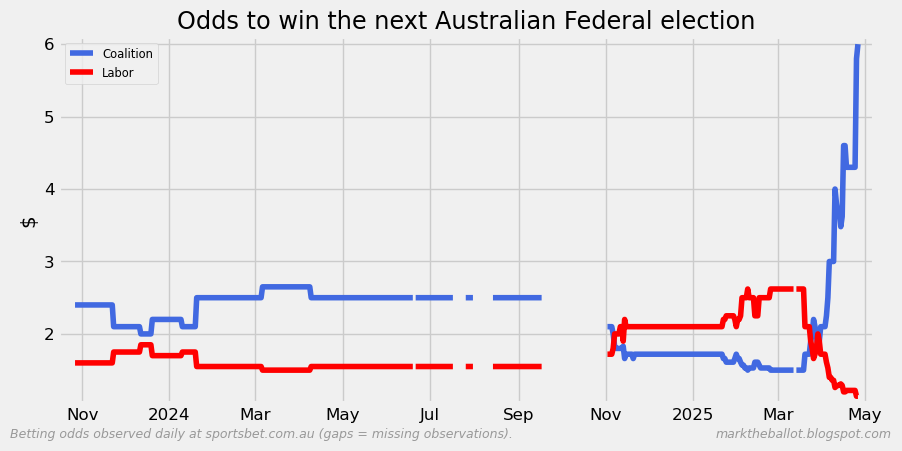

2024-11-02 2025-04-26


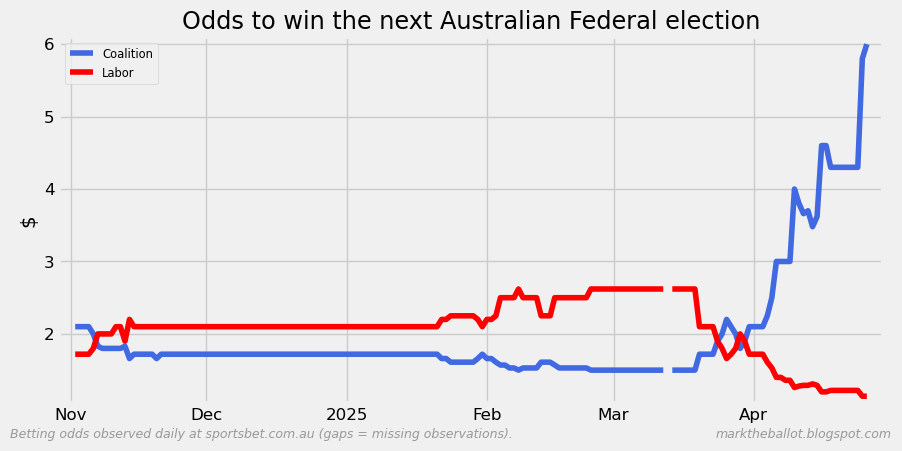

In [5]:
colors = plotting.colorise(data.columns)
for start in (None, "2024-11-02"):
    ax = None
    this_data = data if start is None else data.loc[start:]
    print(this_data.index[0], this_data.index[-1])
    for column, color in zip(this_data.columns, colors):
        ax = this_data[column].plot.line(color=color, ax=ax)
    plotting.finalise_plot(
        ax,
        title="Odds to win the next Australian Federal election",
        xlabel=None,
        ylabel="$",
        legend=plotting.LEGEND_SET,
        concise_dates=True,
        tag="" if start is None else start,
        **footers,
        show=SHOW,
    )

In [6]:
def convert(odds: pd.DataFrame) -> pd.DataFrame:
    # get raw probabilities
    raw_probs = 1 / odds

    # remove the bookmakers over-round
    total = raw_probs.sum(axis=1)
    adj_probs = raw_probs.div(total, axis=0)

    return adj_probs
adj_probs = convert(data) * 100

if SHOW:
    display(adj_probs.tail().round(2))

Party,Coalition,Labor
2025-04-22,22.10,77.90
2025-04-23,22.10,77.90
2025-04-24,22.10,77.90
2025-04-25,16.43,83.57
2025-04-26,15.97,84.03


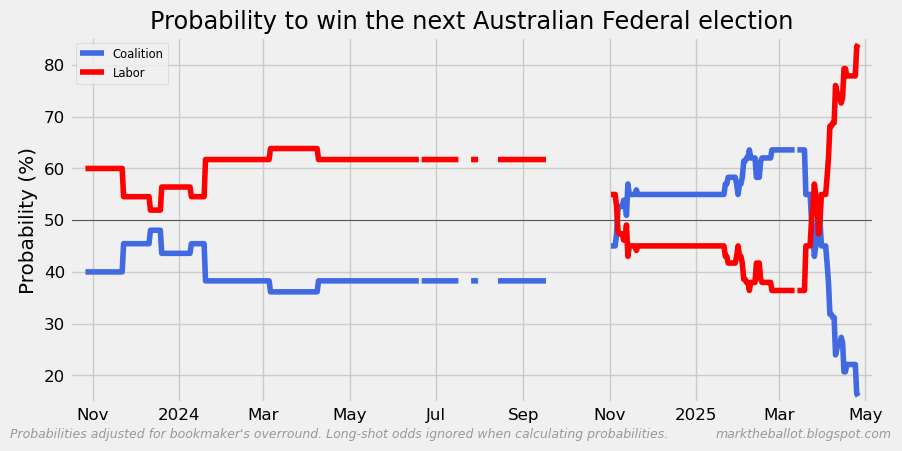

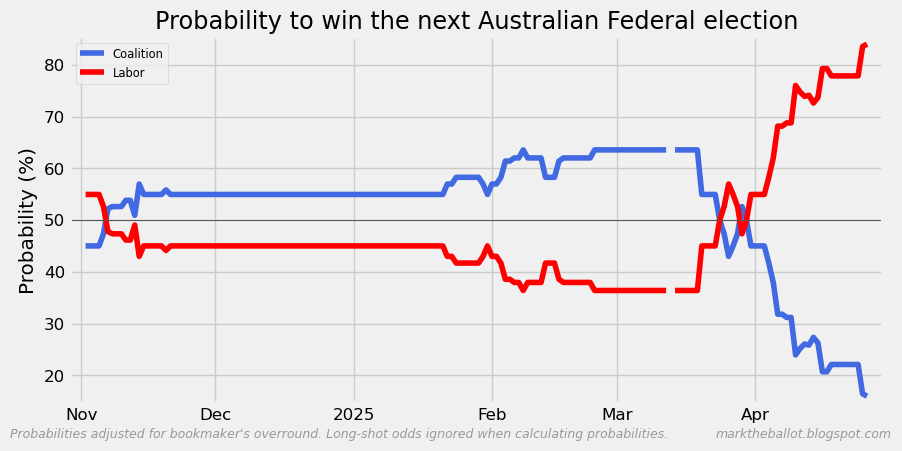

In [7]:
for start in (None, "2024-11-02"):
    ax = None
    this_data = adj_probs if start is None else adj_probs.loc[start:]
    for column, color in zip(adj_probs.columns, colors):
        ax = this_data[column].plot.line(color=color, ax=ax)

    LFOOTER = (
        "Probabilities adjusted for bookmaker's overround. "
        "Long-shot odds ignored when calculating probabilities. "
    )

    plotting.finalise_plot(
        ax,
        title="Probability to win the next Australian Federal election",
        xlabel=None,
        ylabel="Probability (%)",
        legend=plotting.LEGEND_SET,
        concise_dates=True,
        y50=True,
        tag="" if start is None else start,
        rfooter=plotting.RFOOTER,
        lfooter=LFOOTER,
        show=SHOW,
    )

## Finished

In [8]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.1.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.2.3
matplotlib: 3.10.1

Watermark: 2.5.0



In [9]:
print("It is done")

It is done
